In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# 데이터 로드
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/aug_train.csv")

In [4]:
# 이상치들 상한값, 하한값으로 대체
def outlier(df):
    IQR = df.quantile(0.75) - df.quantile(0.25)
    line_down = df.quantile(0.25) - IQR*1.5
    line_up = df.quantile(0.75) + IQR*1.5

    df = df.clip(line_down, line_up)

    return df

df['Annual_Premium'] = outlier(df['Annual_Premium'])

In [5]:
# 필요없는 칼럼 제거
df.drop(['id'], axis = 1, inplace = True)

## Age를 범주화하여 Age_level 생성

모든 기준은 대한민국 평균 연령로 결정  
1) 평균 취업 연령 : 28세  
2) 평균 결혼 및 출산 연령 : 32세  
3) 평균 내 집 마련 연령 : 40세  
4) 평균 은퇴 연령 : 60세   
를 이용해 Age를 범주화하여 Age_level 생성

In [6]:
condition1 = (df['Age'] < 28)
condition2 = (df['Age'] >= 28) & (df['Age'] < 32)
condition3 = (df['Age'] >= 32) & (df['Age'] < 40)
condition4 = (df['Age'] >= 40) & (df['Age'] < 60)
condition5 = (df['Age'] >= 60)

In [7]:
df['Age_level'] = np.where(condition1, 0, np.where(condition2,1,np.where(condition3,2,np.where(condition4,3,np.where(condition5,4,"NaN")))))

In [8]:
df.drop(['Age'],axis= 1, inplace=True)

### 원본데이터와 합쳐서 특징파악을 하기 위해 df_copy 이용
### PCA, 군집화는 df.copy 데이터를 이용해서 진행

In [9]:
# 데이터 합치기 위해 원본데이터 남겨둠
df_copy = df.copy()

## 인코딩 - df_copy 사용

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [11]:
features = ['Gender', 'Vehicle_Damage', 'Vehicle_Age']

In [12]:
for o_col in features:
    encoder = LabelEncoder()
    encoder.fit(df_copy[o_col])
    df_copy[o_col] = encoder.transform(df_copy[o_col])

In [13]:
df_copy = pd.get_dummies(df_copy, columns = ['Age_level'])

In [14]:
df_copy.drop(['Vintage', 'Response'], axis = 1, inplace = True)

## 스케일링 --> PCA를 하기 전 매우 큰 변수만 log변환 해주기

In [15]:
df_copy["Region_Code"] = np.log1p(df_copy["Region_Code"])
df_copy["Annual_Premium"] = np.log1p(df_copy["Annual_Premium"])
df_copy["Policy_Sales_Channel"] = np.log1p(df_copy["Policy_Sales_Channel"])

In [16]:
df_copy

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Age_level_0,Age_level_1,Age_level_2,Age_level_3,Age_level_4
0,1,1,2.079442,1,1,0,7.875119,5.030438,1,0,0,0,0
1,1,1,3.367296,0,0,1,10.676554,3.295837,0,0,0,1,0
2,0,1,3.526361,0,0,1,10.486876,4.828314,0,0,0,0,1
3,0,1,3.526361,0,1,0,10.227236,5.030438,1,0,0,0,0
4,1,1,3.850148,1,1,0,10.275878,5.030438,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
382149,1,1,2.772589,0,1,1,10.083264,5.030438,1,0,0,0,0
382150,1,1,3.367296,1,1,0,11.031681,5.030438,1,0,0,0,0
382151,1,1,3.367296,0,0,1,10.607674,3.295837,0,0,0,1,0
382152,0,1,3.367296,1,1,0,10.141756,5.030438,0,1,0,0,0


## PCA

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(df_copy)
df_copy = pd.DataFrame(data = pca.transform(df_copy), columns=['pc1', 'pc2'])
df_copy.head()

,pc1,pc2
0,0.717828,-2.368226
1,0.697717,1.661204
2,-0.085838,0.506176
3,-0.819555,-0.465690
4,-0.723017,-0.288540


## KMeans 평가지표

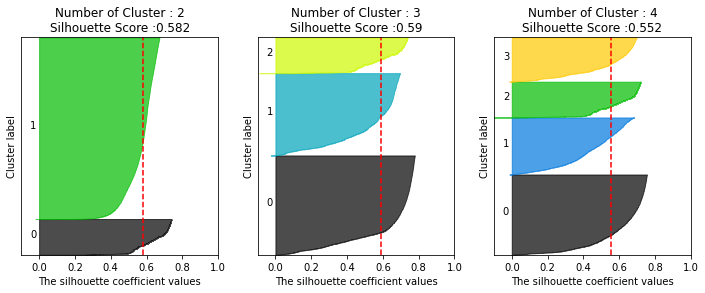

In [18]:
def visualize_silhouette(cluster_lists, X_features):     
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
   
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
   
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
   
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
       
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
       
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

            
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
       
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
           
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

           
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")


# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([2, 3, 4], df_copy)

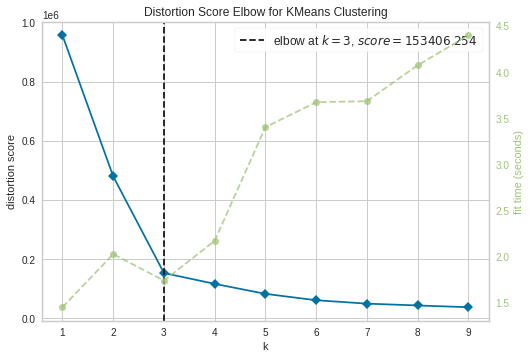

In [35]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(), k=(1,10))

visualizer.fit(df_copy) 
visualizer.poof()

## 실루엣 계수와 Elbow point 확인을 통해 n = 3 선정

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state = 42)
kmeans.fit(df_copy)

df_copy['labels'] = kmeans.predict(df_copy)
df_copy

,pc1,pc2,labels
0,0.717828,-2.368226,2
1,0.697717,1.661204,1
2,-0.085838,0.506176,1
3,-0.819555,-0.465690,0
4,-0.723017,-0.288540,0
...,...,...,...
382149,-0.433640,-0.431887,0
382150,-1.517218,-0.019893,0
382151,0.746392,1.613456,1
382152,-0.705030,-0.507093,0


## 군집화 시각화

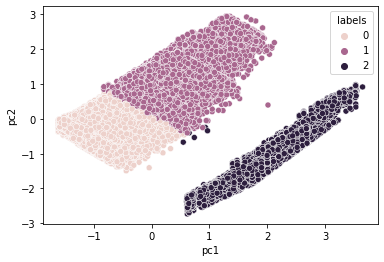

In [21]:
sns.scatterplot(x='pc1', y='pc2', hue='labels', data=df_copy)

## 군집화 특징 비교

In [23]:
df_concat = pd.concat([df, df_copy['labels']], axis = 1)

In [25]:
df_concat.groupby('labels').count()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_level
labels,,,,,,,,,,,
0,174699,174699,174699,174699,174699,174699,174699,174699,174699,174699,174699
1,144574,144574,144574,144574,144574,144574,144574,144574,144574,144574,144574
2,62881,62881,62881,62881,62881,62881,62881,62881,62881,62881,62881


In [26]:
df_concat.groupby(['labels', 'Response']).count()

Gender  Driving_License  Region_Code  Previously_Insured  \
labels Response                                                             
0      0         166296           166296       166296              166296   
       1           8403             8403         8403                8403   
1      0         101264           101264       101264              101264   
       1          43310            43310        43310               43310   
2      0          51993            51993        51993               51993   
       1          10888            10888        10888               10888   

                 Vehicle_Age  Vehicle_Damage  Annual_Premium  \
labels Response                                                
0      0              166296          166296          166296   
       1                8403            8403            8403   
1      0              101264          101264          101264   
       1               43310           43310           43310   
2      0               51993           51993           51993   
       1               10888           10888           10888   

                 Policy_Sales_Channel  Vintage  Age_level  
labels Response                                            
0      0                       166296   166296     166296  
       1                         8403     8403       8403  
1      0                       101264   101264     101264  
       1                        43310    43310      43310  
2      0                        51993    51993      51993  
       1                        10888    10888      10888

In [27]:
df_concat.groupby(['labels', 'Driving_License']).count()

Gender  Region_Code  Previously_Insured  Vehicle_Age  \
labels Driving_License                                                         
0      0                    90           90                  90           90   
       1                174609       174609              174609       174609   
1      0                   524          524                 524          524   
       1                144050       144050              144050       144050   
2      0                   109          109                 109          109   
       1                 62772        62772               62772        62772   

                        Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
labels Driving_License                                                         
0      0                            90              90                    90   
       1                        174609          174609                174609   
1      0                           524             524                   524   
       1                        144050          144050                144050   
2      0                           109             109                   109   
       1                         62772           62772                 62772   

                        Vintage  Response  Age_level  
labels Driving_License                                
0      0                     90        90         90  
       1                 174609    174609     174609  
1      0                    524       524        524  
       1                 144050    144050     144050  
2      0                    109       109        109  
       1                  62772     62772      62772

In [28]:
df_concat.groupby(['labels', 'Age_level']).count()

Gender  Driving_License  Region_Code  Previously_Insured  \
labels Age_level                                                             
0      0          120946           120946       120946              120946   
       1           20591            20591        20591               20591   
       2           12793            12793        12793               12793   
       3           12261            12261        12261               12261   
       4            8108             8108         8108                8108   
1      0            2788             2788         2788                2788   
       1            2884             2884         2884                2884   
       2           20801            20801        20801               20801   
       3           90588            90588        90588               90588   
       4           27513            27513        27513               27513   
2      0           15260            15260        15260               15260   
       1            5686             5686         5686                5686   
       2           10214            10214        10214               10214   
       3           23788            23788        23788               23788   
       4            7933             7933         7933                7933   

                  Vehicle_Age  Vehicle_Damage  Annual_Premium  \
labels Age_level                                                
0      0               120946          120946          120946   
       1                20591           20591           20591   
       2                12793           12793           12793   
       3                12261           12261           12261   
       4                 8108            8108            8108   
1      0                 2788            2788            2788   
       1                 2884            2884            2884   
       2                20801           20801           20801   
       3                90588           90588           90588   
       4                27513           27513           27513   
2      0                15260           15260           15260   
       1                 5686            5686            5686   
       2                10214           10214           10214   
       3                23788           23788           23788   
       4                 7933            7933            7933   

                  Policy_Sales_Channel  Vintage  Response  
labels Age_level                                           
0      0                        120946   120946    120946  
       1                         20591    20591     20591  
       2                         12793    12793     12793  
       3                         12261    12261     12261  
       4                          8108     8108      8108  
1      0                          2788     2788      2788  
       1                          2884     2884      2884  
       2                         20801    20801     20801  
       3                         90588    90588     90588  
       4                         27513    27513     27513  
2      0                         15260    15260     15260  
       1                          5686     5686      5686  
       2                         10214    10214     10214  
       3                         23788    23788     23788  
       4                          7933     7933      7933

In [29]:
df_concat.groupby(['labels', 'Driving_License']).count()

Gender  Region_Code  Previously_Insured  Vehicle_Age  \
labels Driving_License                                                         
0      0                    90           90                  90           90   
       1                174609       174609              174609       174609   
1      0                   524          524                 524          524   
       1                144050       144050              144050       144050   
2      0                   109          109                 109          109   
       1                 62772        62772               62772        62772   

                        Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
labels Driving_License                                                         
0      0                            90              90                    90   
       1                        174609          174609                174609   
1      0                           524             524                   524   
       1                        144050          144050                144050   
2      0                           109             109                   109   
       1                         62772           62772                 62772   

                        Vintage  Response  Age_level  
labels Driving_License                                
0      0                     90        90         90  
       1                 174609    174609     174609  
1      0                    524       524        524  
       1                 144050    144050     144050  
2      0                    109       109        109  
       1                  62772     62772      62772

In [30]:
df_concat.groupby(['labels', 'Previously_Insured']).count()

Gender  Driving_License  Region_Code  Vehicle_Age  \
labels Previously_Insured                                                      
0      0                    46169            46169        46169        46169   
       1                   128530           128530       128530       128530   
1      0                   110921           110921       110921       110921   
       1                    33653            33653        33653        33653   
2      0                    38121            38121        38121        38121   
       1                    24760            24760        24760        24760   

                           Vehicle_Damage  Annual_Premium  \
labels Previously_Insured                                   
0      0                            46169           46169   
       1                           128530          128530   
1      0                           110921          110921   
       1                            33653           33653   
2      0                            38121           38121   
       1                            24760           24760   

                           Policy_Sales_Channel  Vintage  Response  Age_level  
labels Previously_Insured                                                      
0      0                                  46169    46169     46169      46169  
       1                                 128530   128530    128530     128530  
1      0                                 110921   110921    110921     110921  
       1                                  33653    33653     33653      33653  
2      0                                  38121    38121     38121      38121  
       1                                  24760    24760     24760      24760

In [31]:
df_concat.groupby(['labels', 'Vehicle_Age']).count()

Gender  Driving_License  Region_Code  Previously_Insured  \
labels Vehicle_Age                                                             
0      1-2 Year      26566            26566        26566               26566   
       < 1 Year     142696           142696       142696              142696   
       > 2 Years      5437             5437         5437                5437   
1      1-2 Year     133129           133129       133129              133129   
       < 1 Year       3767             3767         3767                3767   
       > 2 Years      7678             7678         7678                7678   
2      1-2 Year      40481            40481        40481               40481   
       < 1 Year      19890            19890        19890               19890   
       > 2 Years      2510             2510         2510                2510   

                    Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
labels Vehicle_Age                                                         
0      1-2 Year              26566           26566                 26566   
       < 1 Year             142696          142696                142696   
       > 2 Years              5437            5437                  5437   
1      1-2 Year             133129          133129                133129   
       < 1 Year               3767            3767                  3767   
       > 2 Years              7678            7678                  7678   
2      1-2 Year              40481           40481                 40481   
       < 1 Year              19890           19890                 19890   
       > 2 Years              2510            2510                  2510   

                    Vintage  Response  Age_level  
labels Vehicle_Age                                
0      1-2 Year       26566     26566      26566  
       < 1 Year      142696    142696     142696  
       > 2 Years       5437      5437       5437  
1      1-2 Year      133129    133129     133129  
       < 1 Year        3767      3767       3767  
       > 2 Years       7678      7678       7678  
2      1-2 Year       40481     40481      40481  
       < 1 Year       19890     19890      19890  
       > 2 Years       2510      2510       2510

In [32]:
df_concat.groupby(['labels', 'Vehicle_Damage']).count()

Gender  Driving_License  Region_Code  \
labels Vehicle_Damage                                         
0      No              133742           133742       133742   
       Yes              40957            40957        40957   
1      No               37222            37222        37222   
       Yes             107352           107352       107352   
2      No               27537            27537        27537   
       Yes              35344            35344        35344   

                       Previously_Insured  Vehicle_Age  Annual_Premium  \
labels Vehicle_Damage                                                    
0      No                          133742       133742          133742   
       Yes                          40957        40957           40957   
1      No                           37222        37222           37222   
       Yes                         107352       107352          107352   
2      No                           27537        27537           27537   
       Yes                          35344        35344           35344   

                       Policy_Sales_Channel  Vintage  Response  Age_level  
labels Vehicle_Damage                                                      
0      No                            133742   133742    133742     133742  
       Yes                            40957    40957     40957      40957  
1      No                             37222    37222     37222      37222  
       Yes                           107352   107352    107352     107352  
2      No                             27537    27537     27537      27537  
       Yes                            35344    35344     35344      35344

In [33]:
df_concat.groupby(['labels', 'Annual_Premium']).count()

Gender  Driving_License  Region_Code  \
labels Annual_Premium                                         
0      7670.0               1                1            1   
       9816.0               1                1            1   
       10004.0              1                1            1   
       10576.0              1                1            1   
       10761.0              1                1            1   
...                       ...              ...          ...   
2      10328.0              1                1            1   
       10680.0              1                1            1   
       10922.0              1                1            1   
       11457.0              1                1            1   
       13889.0              1                1            1   

                       Previously_Insured  Vehicle_Age  Vehicle_Damage  \
labels Annual_Premium                                                    
0      7670.0                           1            1               1   
       9816.0                           1            1               1   
       10004.0                          1            1               1   
       10576.0                          1            1               1   
       10761.0                          1            1               1   
...                                   ...          ...             ...   
2      10328.0                          1            1               1   
       10680.0                          1            1               1   
       10922.0                          1            1               1   
       11457.0                          1            1               1   
       13889.0                          1            1               1   

                       Policy_Sales_Channel  Vintage  Response  Age_level  
labels Annual_Premium                                                      
0      7670.0                             1        1         1          1  
       9816.0                             1        1         1          1  
       10004.0                            1        1         1          1  
       10576.0                            1        1         1          1  
       10761.0                            1        1         1          1  
...                                     ...      ...       ...        ...  
2      10328.0                            1        1         1          1  
       10680.0                            1        1         1          1  
       10922.0                            1        1         1          1  
       11457.0                            1        1         1          1  
       13889.0                            1        1         1          1  

[72843 rows x 10 columns]

In [34]:
df_concat.groupby(['labels', 'Policy_Sales_Channel']).count()

Gender  Driving_License  Region_Code  \
labels Policy_Sales_Channel                                         
0      26.0                     707              707          707   
       31.0                       2                2            2   
       52.0                       2                2            2   
       55.0                       3                3            3   
       60.0                       7                7            7   
...                             ...              ...          ...   
2      157.0                   4331             4331         4331   
       158.0                    345              345          345   
       159.0                     26               26           26   
       160.0                   5227             5227         5227   
       163.0                    907              907          907   

                             Previously_Insured  Vehicle_Age  Vehicle_Damage  \
labels Policy_Sales_Channel                                                    
0      26.0                                 707          707             707   
       31.0                                   2            2               2   
       52.0                                   2            2               2   
       55.0                                   3            3               3   
       60.0                                   7            7               7   
...                                         ...          ...             ...   
2      157.0                               4331         4331            4331   
       158.0                                345          345             345   
       159.0                                 26           26              26   
       160.0                               5227         5227            5227   
       163.0                                907          907             907   

                             Annual_Premium  Vintage  Response  Age_level  
labels Policy_Sales_Channel                                                
0      26.0                             707      707       707        707  
       31.0                               2        2         2          2  
       52.0                               2        2         2          2  
       55.0                               3        3         3          3  
       60.0                               7        7         7          7  
...                                     ...      ...       ...        ...  
2      157.0                           4331     4331      4331       4331  
       158.0                            345      345       345        345  
       159.0                             26       26        26         26  
       160.0                           5227     5227      5227       5227  
       163.0                            907      907       907        907  

[351 rows x 10 columns]